# **_Atividade de Programação Natural de Linguagem (PNL) - Parte 2_**
### **_Alunos:_** Ana Luiza F. Gouveia, Luiz Flavio Pereira
_____________________________________

Análise do dataset _Emotion Dataset for NLP_, disponível em https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp, traduzido para português.

O dataset original em inglês foi traduzido de forma online para português, através do Google Translate, a fim de ser possível a análise e comparação das técnicas de PNL entre diferentes idiomas.

O presente trabalho possui por objetivo efetuar a análise do dataset através das técnicas de Análise de PNL associadas às técnicas de _Machine Learning_, com o intuito de tornar possível a identificação do sentimento implícito em um texto _inputado_ por um usuário.
_______________________________________

In [ ]:
# Importação das bibliotecas necessárias à execução do programa

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

sns.set()

import nltk
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords

!pip install unidecode
import unidecode

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

RANDOM_STATE = 42

In [ ]:
# Download da base de dados do stopwords da biblioteca NLTK para Português

nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))
print('\nLista de stopwords em português: ')
print(stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!

Lista de stopwords em português: 
{'houveram', 'hão', 'aquelas', 'nos', 'havemos', 'teus', 'nós', 'por', 'qual', 'aquele', 'sejamos', 'tive', 'tiveram', 'houverei', 'houvéssemos', 'estivera', 'foi', 'como', 'tenhamos', 'tivera', 'era', 'nossas', 'essa', 'e', 'nem', 'numa', 'estivesse', 'tivesse', 'este', 'essas', 'estivessem', 'há', 'mesmo', 'houveria', 'quando', 'entre', 'de', 'depois', 'também', 'suas', 'tivéssemos', 'ao', 'houvesse', 'nas', 'às', 'estiveram', 'houveremos', 'tinha', 'terá', 'tinham', 'esse', 'tua', 'pelo', 'estavam', 'se', 'houverá', 'serão', 'das', 'já', 'forem', 'esses', 'estas', 'nosso', 'estejam', 'estivermos', 'seriam', 'lhes', 'aquela', 'tém', 'sua', 'será', 'mas', 'ou', 'com', 'hajamos', 'seja', 'tivemos', 'em', 'quem', 'sem', 'minha', 'estávamos', 'dos', 'for', 'temos', 'seria', 'nossos', 'fui', 'vocês', 'fosse', 'tu', 'estes', 'houvermos', 

In [ ]:
# Função para tratamento do texto para possibilitar a entrada no algoritmo de Machine Learning.

def text_process(original_sentences):

    # Minimização dos caracteres, a fim de se evitar a diferenciação pelo algoritmo entre letras maiúsculas e minúsculas.
    original_sentences = original_sentences.lower()
    
    # Remoção da pontuação e reagrupamento da string de texto.
    processing = [char for char in original_sentences if char not in string.punctuation]
    processing = ''.join(processing)

    # Remoção dos stopwords das frases e reagrupamento da string de texto.
    processing = [word for word in processing.split() if word not in stop_words]
    processing = ' '.join(processing)

    # Remoção da acentuação das palavras do texto.
    word_seq = unidecode.unidecode(processing)

    return word_seq

In [ ]:
# Função para exibição das métricas de medição de desempenho do algoritmo, de acordo com o resultado predito e o verdadeiro.
# Devido às características do texto, duas métricas se mostraram mais adequadas à análise, sendo elas a acurácia e o F1-score.

def mostra_metricas(y_true, y_pred):
    print("Acurácia: ", accuracy_score(y_true, y_pred))
    print("F1-Score:", f1_score(y_true, y_pred, average='weighted'))

In [ ]:
# Função para plotagem da Matriz de Confusão para comparação dos modelos.
# A função plota duas matrizes, uma para o modelo Bag of Words (BoW) e outra para o modelo Term Frequency – Inverse Document Frequency (TF-IDF)

def print_confusion_matrix(y_test1, y_pred1, y_test2, y_pred2):
    print("\nMatriz de confusão:")

    fig = plt.figure(figsize=(15,5))
    plt.subplots_adjust(wspace=0.25, hspace=0.05)
    plt.suptitle('Comparativo entre os vetorizadores BoW e TF-IDF')

    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_test1, y_pred1), annot=True, cbar=False, fmt='d', xticklabels=nomes, yticklabels=nomes)
    plt.title('BoW')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y_test2, y_pred2), annot=True, cbar=False, fmt='d', xticklabels=nomes, yticklabels=nomes)
    plt.title('TF-IDF')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0) 

    plt.show()

    return

In [ ]:
# Nomes das colunas do Dataframe
columns = ['texto', 'emocao']

In [ ]:
# Importação do dataframe dos arquivos de texto do dataset

train_df = pd.read_csv('train_pt.txt', delimiter=';', header=None, names=columns)
test_df = pd.read_csv('test_pt.txt', delimiter=';', header=None, names=columns)
val_df = pd.read_csv('val_pt.txt', delimiter=';', header=None, names=columns)

In [ ]:
# Devido ao fato do dataset ter sido disponibilizado em três arquivos separados, foi-se optado por uní-los e dividir o dataframe completo em duas partes: treino e teste.
# Essa escolha veio do fato dos arquivos de teste e validação não estarem categorizados de forma homogênea, podendo induzir o algoritmo a erros.

emotion_df = pd.concat([train_df, test_df, val_df])
print(f'O dataset emotion_df tem {emotion_df.shape[0]} linhas e {emotion_df.shape[1]} colunas.')

O dataset emotion_df tem 20000 linhas e 2 colunas.


In [ ]:
# Script para identificação de entradas duplicadas.

repetidos = round(sum(emotion_df.duplicated("texto")))
print(f"O dataset possui {repetidos} entradas de texto duplicadas.")

O dataset possui 75 entradas de texto duplicadas.


In [ ]:
# Exibição dos textos duplicados

emotion_df[emotion_df.duplicated("texto", keep =  False)].sort_values(by = "texto")

,texto,emocao
2949,Afasto-me de canções que falam sobre como me s...,amor
15329,Afasto-me de canções que falam sobre como me s...,alegria
8804,Aposto que Taylor Swift se deleita sabendo que...,medo
15572,Aposto que Taylor Swift se deleita sabendo que...,raiva
7685,Eu ainda não tenho certeza por que Reilly sent...,surpresa
...,...,...
8557,me sinto meio estranho,medo
6034,"não realizei uma pesquisa, mas é bastante prov...",medo
1026,"não realizei uma pesquisa, mas é bastante prov...",tristeza
917,sinto a necessidade de tornar isso desde raini...,alegria


In [ ]:
# Remoção dos textos duplicados e confirmação da limpeza

emotion_df.drop_duplicates("texto", inplace = True)

repetidos = round(sum(emotion_df.duplicated("texto")))
print(f"O dataset possui {repetidos} entradas de texto duplicadas.")

O dataset possui 0 entradas de texto duplicadas.


In [ ]:
# Contagem da distribuição das categorias de sentimentos

emotion_df['emocao'].value_counts()

alegria     6737
tristeza    5782
raiva       2698
medo        2366
amor        1629
surpresa     713
Name: emocao, dtype: int64

In [ ]:
print(f'O dataset emotion_df tem {emotion_df.shape[0]} linhas e {emotion_df.shape[1]} colunas.')

O dataset emotion_df tem 19925 linhas e 2 colunas.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


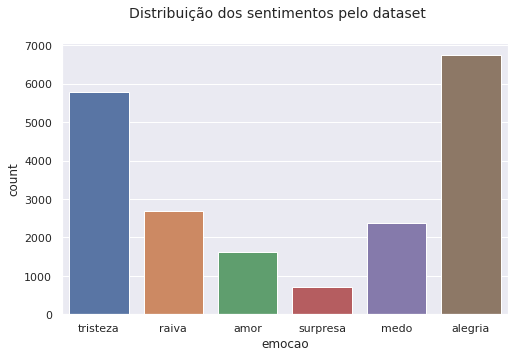

In [ ]:
# Gráfico da distribuição das categorias

_ = fig = plt.figure(figsize=(8,5))
_ = plt.suptitle('Distribuição dos sentimentos pelo dataset', fontsize=14)
_ = sns.countplot(emotion_df['emocao'])

In [ ]:
# Distribuição percentual das categorias

perc = round((emotion_df['emocao'].value_counts()*100) / len(emotion_df['emocao']), 2)
perc

alegria     33.81
tristeza    29.02
raiva       13.54
medo        11.87
amor         8.18
surpresa     3.58
Name: emocao, dtype: float64

In [ ]:
# Primeiras dez linhas do dataframe inalterado

print(emotion_df.head(10))

                                               texto    emocao
0                          eu não me senti humilhado  tristeza
1  Eu posso passar de um sentimento de desesperan...  tristeza
2  estou pegando um minuto para postar me sinto g...     raiva
3  Estou sempre com saudades da lareira, saberei ...      amor
4                     estou me sentindo mal-humorado     raiva
5  Eu tenho me sentido um pouco sobrecarregado ul...  tristeza
6  Tenho tomado ou miligramas ou vezes a quantida...  surpresa
7  Eu me sinto tão confuso sobre a vida como um a...      medo
8  Estou com a Petronas há anos e sinto que a Pet...   alegria
9                          também me sinto romântico      amor


In [ ]:
# Aplicação da função de transformação do texto na coluna de texto e impressão das dez primeiras linhas da dataset alterado

processed_text = emotion_df['texto'].apply(text_process)
processed_text.head(10)

0                                      senti humilhado
1    posso passar sentimento desesperanca maldita e...
2        pegando minuto postar sinto ganancioso errado
3    sempre saudades lareira saberei ainda propriedade
4                                 sentindo malhumorado
5    sentido pouco sobrecarregado ultimamente certe...
6    tomado miligramas vezes quantidade recomendada...
7    sinto tao confuso sobre vida adolescente tao c...
8    petronas anos sinto petronas bom desempenho lu...
9                                      sinto romantico
Name: texto, dtype: object

In [ ]:
# Transformação das categorias em valores numéricos para entrada no algoritmo de Machine Learning

ordinal_encoder = OrdinalEncoder()
ord_encoder_emotion = ordinal_encoder.fit_transform(emotion_df[['emocao']])
ordinal_encoder.categories_

[array(['alegria', 'amor', 'medo', 'raiva', 'surpresa', 'tristeza'],
       dtype=object)]

In [ ]:
# Extração dos nomes das categorias na ordem do Encoder para possibilitar a identificação coreta na Matrix de Confusão

nomes = ['alegria', 'amor', 'medo', 'raiva', 'surpresa', 'tristeza']

In [ ]:
# Instanciação do vetorizador do Bag of Words. Foi-se optado pela classificação binária dos tokens, mínimo de duas palavras e máximo e ocorrência máxima de 85%

text = processed_text

vectorizer = CountVectorizer(binary=True, min_df=2, max_df=0.85)
X_bow = vectorizer.fit_transform(text)
X_bow.toarray()
print(f'A matriz BoW tem {X_bow.shape[0]} linhas por {X_bow.shape[1]} colunas e eh do tipo {type(X_bow)}')

A matriz BoW tem 19925 linhas por 9508 colunas e eh do tipo <class 'scipy.sparse.csr.csr_matrix'>


In [ ]:
# Instanciação do vetorizador do TF-IDF. Foi-se optado pelo mínimo de duas palavras e ocorrência máxima de 85%

tfidf_vect = TfidfVectorizer(min_df=2, max_df=0.85)
X_tfidf = tfidf_vect.fit_transform(text)
print(f'A matriz TF-IDF tem {X_tfidf.shape[0]} linhas por {X_tfidf.shape[1]} colunas e eh do tipo {type(X_tfidf.shape)}')

A matriz TF-IDF tem 19925 linhas por 9508 colunas e eh do tipo <class 'tuple'>


In [ ]:
# Sepearação do dataframe em sets de treino e teste.
# X1 e y1 se referem ao vetorizados BoW. X2 e y2 se referem ao vetorizador TF-IDF

X1_train, X1_test, y1_train, y1_test = train_test_split(X_bow, ord_encoder_emotion, test_size=0.2, random_state=RANDOM_STATE, stratify=ord_encoder_emotion)
X2_train, X2_test, y2_train, y2_test = train_test_split(X_tfidf, ord_encoder_emotion, test_size=0.2, random_state=RANDOM_STATE, stratify=ord_encoder_emotion)

y1_train = y1_train.ravel()
y2_train = y2_train.ravel()

In [ ]:
print(f'O dataset de treino possui {X1_train.shape[0]} linhas e o de teste {X1_test.shape[0]} linhas.')

O dataset de treino possui 15940 linhas e o de teste 3985 linhas.


Metricas para BoW:
Acurácia:  0.7894604767879548
F1-Score: 0.7854355822990111

Metricas para TF-IDF:
Acurácia:  0.7575909661229611
F1-Score: 0.7452364883044499

Matriz de confusão:


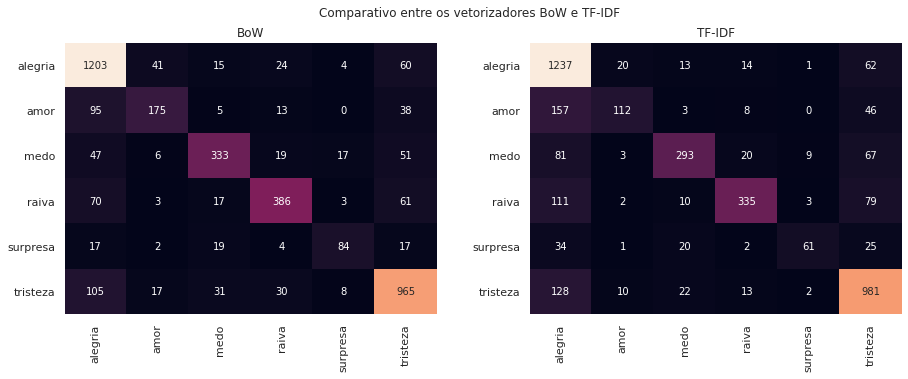

In [ ]:
# Aplicação do algoritmo de Machine Learning Logistic Regression para o BoW e para o TF-IDF

print('Metricas para BoW:')
reglog = LogisticRegression(max_iter=1000, fit_intercept=True)
reglog.fit(X1_train, y1_train)
y1_pred = reglog.predict(X1_test)
y_reglog = y1_pred
mostra_metricas(y1_test, y1_pred)

print('\nMetricas para TF-IDF:')
reglog.fit(X2_train, y2_train)
y2_pred = reglog.predict(X2_test)
mostra_metricas(y2_test, y2_pred)

print_confusion_matrix(y1_test, y1_pred, y2_test, y2_pred)

Metricas para BoW:
Acurácia:  0.7570890840652447
F1-Score: 0.7530526071865205

Metricas para TF-IDF:
Acurácia:  0.7525721455457968
F1-Score: 0.7462831771860781

Matriz de confusão:


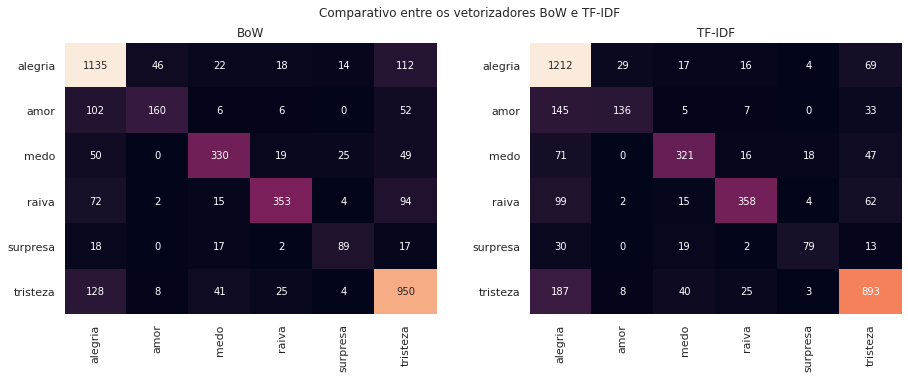

In [ ]:
# Aplicação do algoritmo de Machine Learning Random Forest para o BoW e para o TF-IDF

print('Metricas para BoW:')
rf = RandomForestClassifier()
rf.fit(X1_train, y1_train)
y1_pred = rf.predict(X1_test)
y_rf = y1_pred
mostra_metricas(y1_test, y1_pred)

print('\nMetricas para TF-IDF:')
rf.fit(X2_train, y2_train)
y2_pred = rf.predict(X2_test)
mostra_metricas(y2_test, y2_pred)

print_confusion_matrix(y1_test, y1_pred, y2_test, y2_pred)

Os algoritmos de Machine Learning abaixo foram testados e retornaram resultados muito inferiores aos dois anteriores, sendo mantidos aqui apenas comentados, caso haja interesse de sua execução posterior.

In [ ]:
'''
# Aplicação do algoritmo de Machine Learning kNN para o BoW e para o TF-IDF

print('Metricas para BoW:')
knn = KNeighborsClassifier()
knn.fit(X1_train, y1_train)
y1_pred = knn.predict(X1_test)
mostra_metricas(y1_test, y1_pred)

print('\nMetricas para TF-IDF:')
knn.fit(X2_train, y2_train)
y2_pred = knn.predict(X2_test)
mostra_metricas(y2_test, y2_pred)

print_confusion_matrix(y1_test, y1_pred, y2_test, y2_pred)
'''

"\n# Aplicação do algoritmo de Machine Learning kNN para o BoW e para o TF-IDF\n\nprint('Metricas para BoW:')\nknn = KNeighborsClassifier()\nknn.fit(X1_train, y1_train)\ny1_pred = knn.predict(X1_test)\nmostra_metricas(y1_test, y1_pred)\n\nprint('\nMetricas para TF-IDF:')\nknn.fit(X2_train, y2_train)\ny2_pred = knn.predict(X2_test)\nmostra_metricas(y2_test, y2_pred)\n\nprint_confusion_matrix(y1_test, y1_pred, y2_test, y2_pred)\n"

In [ ]:
'''
# Aplicação do algoritmo de Machine Learning Decision Trees para o BoW e para o TF-IDF

print('Metricas para BoW:')
dt = DecisionTreeClassifier()
dt.fit(X1_train, y1_train)
y1_pred = dt.predict(X1_test)
mostra_metricas(y1_test, y1_pred)

print('\nMetricas para TF-IDF:')
dt.fit(X2_train, y2_train)
y2_pred = dt.predict(X2_test)
mostra_metricas(y2_test, y2_pred)

print_confusion_matrix(y1_test, y1_pred, y2_test, y2_pred)
'''

"\n# Aplicação do algoritmo de Machine Learning Decision Trees para o BoW e para o TF-IDF\n\nprint('Metricas para BoW:')\ndt = DecisionTreeClassifier()\ndt.fit(X1_train, y1_train)\ny1_pred = dt.predict(X1_test)\nmostra_metricas(y1_test, y1_pred)\n\nprint('\nMetricas para TF-IDF:')\ndt.fit(X2_train, y2_train)\ny2_pred = dt.predict(X2_test)\nmostra_metricas(y2_test, y2_pred)\n\nprint_confusion_matrix(y1_test, y1_pred, y2_test, y2_pred)\n"

In [ ]:
'''
# Aplicação do algoritmo de Machine Learning Multinomial Naive-Bayes para o BoW e para o TF-IDF

print('Metricas para BoW:')
mnb = MultinomialNB()
mnb.fit(X1_train.toarray(), y1_train)
y1_pred = mnb.predict(X1_test)
mostra_metricas(y1_test, y1_pred)

print('\nMetricas para TF-IDF:')
mnb.fit(X2_train.toarray(), y2_train)
y2_pred = mnb.predict(X2_test)
mostra_metricas(y2_test, y2_pred)

print_confusion_matrix(y1_test, y1_pred, y2_test, y2_pred)
'''

"\n# Aplicação do algoritmo de Machine Learning Multinomial Naive-Bayes para o BoW e para o TF-IDF\n\nprint('Metricas para BoW:')\nmnb = MultinomialNB()\nmnb.fit(X1_train.toarray(), y1_train)\ny1_pred = mnb.predict(X1_test)\nmostra_metricas(y1_test, y1_pred)\n\nprint('\nMetricas para TF-IDF:')\nmnb.fit(X2_train.toarray(), y2_train)\ny2_pred = mnb.predict(X2_test)\nmostra_metricas(y2_test, y2_pred)\n\nprint_confusion_matrix(y1_test, y1_pred, y2_test, y2_pred)\n"

In [ ]:
'''
# Aplicação do algoritmo de Machine Learning SVC para o BoW e para o TF-IDF

print('Metricas para BoW:')
svc = SVC()
svc.fit(X1_train, y1_train)
y1_pred = svc.predict(X1_test)
mostra_metricas(y1_test, y1_pred)

print('\nMetricas para TF-IDF:')
svc.fit(X2_train, y2_train)
y2_pred = svc.predict(X2_test)
mostra_metricas(y2_test, y2_pred)

print_confusion_matrix(y1_test, y1_pred, y2_test, y2_pred)
'''

"\n# Aplicação do algoritmo de Machine Learning SVC para o BoW e para o TF-IDF\n\nprint('Metricas para BoW:')\nsvc = SVC()\nsvc.fit(X1_train, y1_train)\ny1_pred = svc.predict(X1_test)\nmostra_metricas(y1_test, y1_pred)\n\nprint('\nMetricas para TF-IDF:')\nsvc.fit(X2_train, y2_train)\ny2_pred = svc.predict(X2_test)\nmostra_metricas(y2_test, y2_pred)\n\nprint_confusion_matrix(y1_test, y1_pred, y2_test, y2_pred)\n"


Matriz de confusão:


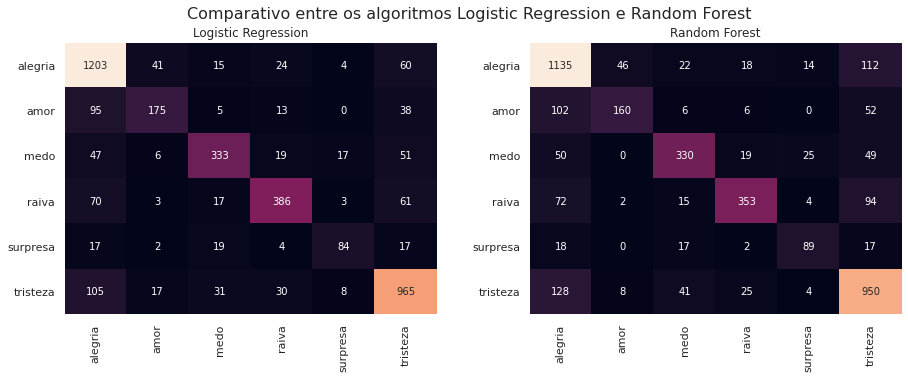

In [ ]:
# Comparação entre os melhores modelos.
# O vetorizador BoW retornou melhores resultados e por isso foi selecionado para continuidade da atividade

print("\nMatriz de confusão:")

fig = plt.figure(figsize=(15,5))
plt.subplots_adjust(wspace=0.25, hspace=0.05)
plt.suptitle('Comparativo entre os algoritmos Logistic Regression e Random Forest\n\n', fontsize=16)

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y1_test, y_reglog), annot=True, cbar=False, fmt='d', xticklabels=nomes, yticklabels=nomes)
plt.title('Logistic Regression')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y1_test, y_rf), annot=True, cbar=False, fmt='d', xticklabels=nomes, yticklabels=nomes)
plt.title('Random Forest')
plt.xticks(rotation=90)
plt.yticks(rotation=0) 

plt.show()

In [ ]:
alegria = amor = medo = raiva = surpresa = tristeza = 0

for i in (y1_test):
    if i == 0:
        alegria = alegria + 1
    elif i == 1:
        amor = amor + 1
    elif i == 2:
        medo = medo + 1
    elif i == 3:
        raiva = raiva + 1
    elif i == 4:
        surpresa = surpresa + 1
    elif i == 5:
        tristeza = tristeza + 1

print(f'Alegria: {alegria}, Amor: {amor}, Medo: {medo}, Raiva: {raiva}, Surpresa: {surpresa}, Tristeza: {tristeza}' )

Alegria: 1347, Amor: 326, Medo: 473, Raiva: 540, Surpresa: 143, Tristeza: 1156


In [ ]:
# Devido ao fato do algoritmo estar correlacionando fortemente os sentimentos amor e alegria e também pelo fato
# de se supor que a pessoa que ama estah feliz (pelo menos deveria...), as entradas dos dois sentimentos foram unidos no sentimento alegria

new_emotion_df = emotion_df.replace({'emocao':'amor'}, 'alegria')
new_emotion_df['emocao'].value_counts()

alegria     8366
tristeza    5782
raiva       2698
medo        2366
surpresa     713
Name: emocao, dtype: int64

In [ ]:
print(f'O dataset alterado possui {new_emotion_df.shape[0]} linhas por {new_emotion_df.shape[1]} colunas.')

O dataset alterado possui 19925 linhas por 2 colunas.


In [ ]:
# Transformação das categorias do dataset alterado para variáveis numéricas

ordinal_encoder = OrdinalEncoder()
ord_encoder_emotion_alt = ordinal_encoder.fit_transform(new_emotion_df[['emocao']])
ordinal_encoder.categories_

[array(['alegria', 'medo', 'raiva', 'surpresa', 'tristeza'], dtype=object)]

In [ ]:
# Separação do dataframe alterado em sets de treino e teste. Apenas o vetorizador BoW será utilizado pois demonstrou melhores métricas

X1_train_alt, X1_test_alt, y1_train_alt, y1_test_alt = train_test_split(X_bow, ord_encoder_emotion_alt, test_size=0.2, random_state=RANDOM_STATE, stratify=ord_encoder_emotion_alt)
y1_train_alt = y1_train_alt.ravel()

In [ ]:
print(f'O dataset de treino possui {X1_train_alt.shape[0]} linhas e o de teste {X1_test_alt.shape[0]} linhas.')

O dataset de treino possui 15940 linhas e o de teste 3985 linhas.


In [ ]:
nomes_alt = ['alegria', 'medo', 'raiva', 'surpresa', 'tristeza']

Metricas para Logistic Regression:
Acurácia:  0.8193224592220828
F1-Score: 0.8168166794777322

Metricas para Random Forest:
Acurácia:  0.8100376411543287
F1-Score: 0.8082687921008441

Matriz de confusão:


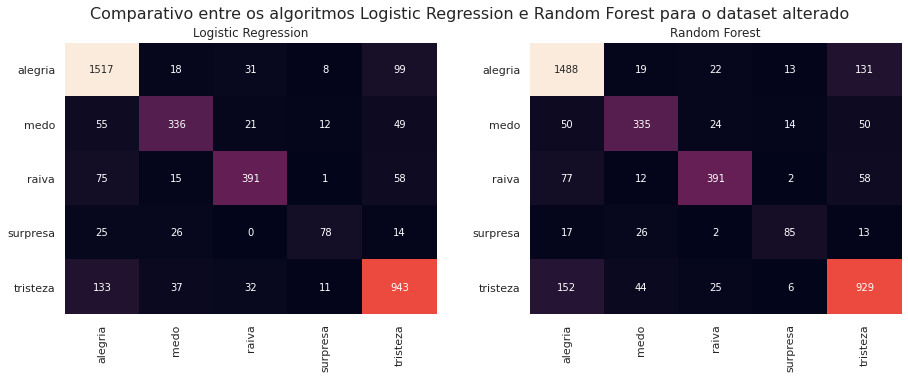

In [ ]:
print('Metricas para Logistic Regression:')
reglog2 = LogisticRegression(max_iter=1000, fit_intercept=True)
reglog2.fit(X1_train_alt, y1_train_alt)
reglog2_y1_pred = reglog2.predict(X1_test_alt)
mostra_metricas(y1_test_alt, reglog2_y1_pred)

print('\nMetricas para Random Forest:')
rf2 = RandomForestClassifier()
rf2.fit(X1_train_alt, y1_train_alt)
rf2_y1_pred = rf2.predict(X1_test_alt)
mostra_metricas(y1_test_alt, rf2_y1_pred)


print("\nMatriz de confusão:")

fig = plt.figure(figsize=(15,5))
plt.subplots_adjust(wspace=0.25, hspace=0.05)
plt.suptitle('Comparativo entre os algoritmos Logistic Regression e Random Forest para o dataset alterado\n\n', fontsize=16)

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y1_test_alt, reglog2_y1_pred), annot=True, cbar=False, fmt='d', xticklabels=nomes_alt, yticklabels=nomes_alt)
plt.title('Logistic Regression')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y1_test_alt, rf2_y1_pred), annot=True, cbar=False, fmt='d', xticklabels=nomes_alt, yticklabels=nomes_alt)
plt.title('Random Forest')
plt.xticks(rotation=90)
plt.yticks(rotation=0) 

plt.show()


Matriz de confusão:


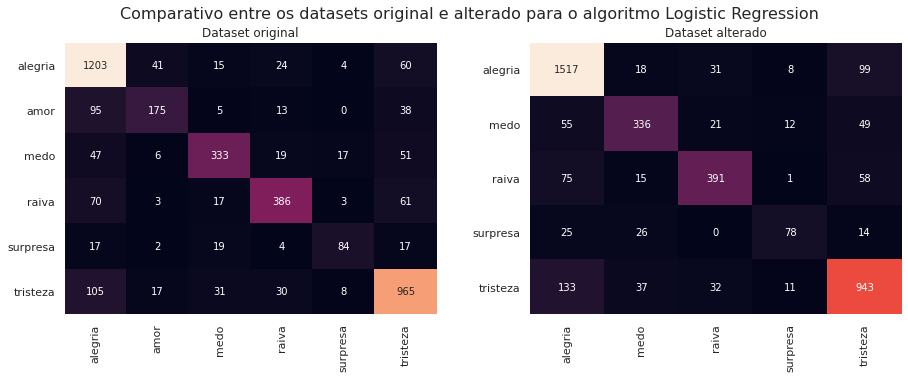

In [ ]:
# O set de testes original possui 326 entradas para a variável amor. No set de treino alterado houve um incremento de 314 entradas
# para a variável alegria e um ligeiro reajuste para as demais variáveis, mais acentuado para a variável tristeza, jah esperado
# por possuir mais entradas que os outros, com exceção da alegria.

print("\nMatriz de confusão:")

fig = plt.figure(figsize=(15,5))
plt.subplots_adjust(wspace=0.25, hspace=0.05)
plt.suptitle('Comparativo entre os datasets original e alterado para o algoritmo Logistic Regression\n', fontsize=16)

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y1_test, y_reglog), annot=True, cbar=False, fmt='d', xticklabels=nomes, yticklabels=nomes)
plt.title('Dataset original')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y1_test_alt, reglog2_y1_pred), annot=True, cbar=False, fmt='d', xticklabels=nomes_alt, yticklabels=nomes_alt)
plt.title('Dataset alterado')
plt.xticks(rotation=90)
plt.yticks(rotation=0) 

plt.show()

In [ ]:
resultados = {0:'alegria', 1:'amor', 2:'medo', 3:'raiva', 4:'surpresa', 5:'tristeza'}
resultados_ajust = {0:'alegria', 1:'medo', 2:'raiva', 3:'surpresa', 4:'tristeza'}

In [ ]:
# Função para predição da entrada de texto do usuário baseada no dataset original

def nova_predicao(texto):
    texto_vetorizado = vectorizer.transform([texto])
    pred_reglog_bow = reglog.predict(texto_vetorizado)

    print(f'A classificação para RegLog com o dataset inalterado foi: {resultados.get(pred_reglog_bow[0])}')

In [ ]:
# Função para predição da entrada de texto do usuário baseada no dataset alterado.
# Apesar da piora na distribuição das variáveis, serah mantida para fins didáticos

def nova_predicao_ajust(texto):
    texto_vetorizado = vectorizer.transform([texto])
    pred2_reglog_bow_alt = reglog2.predict(texto_vetorizado)

    print(f'\nA classificação para RegLog com o dataset alterado foi: {resultados_ajust.get(pred2_reglog_bow_alt[0])}')

In [ ]:
# Ouro de Tolo - Raul Seixas
nova_predicao("Eu devia estar contente Por ter conseguido tudo o que eu quis Mas confesso abestalhado Que eu estou decepcionado")
nova_predicao_ajust("Eu devia estar contente Por ter conseguido tudo o que eu quis Mas confesso abestalhado Que eu estou decepcionado")

A classificação para RegLog com o dataset inalterado foi: alegria

A classificação para RegLog com o dataset alterado foi: alegria


In [ ]:
# Camila Camila - Nenhum de Nós
nova_predicao("E eu que tenho medo até do seu olhar Mas o ódio cega e você não percebe Mas o ódio cega")
nova_predicao_ajust("E eu que tenho medo até do seu olhar Mas o ódio cega e você não percebe Mas o ódio cega")

A classificação para RegLog com o dataset inalterado foi: medo

A classificação para RegLog com o dataset alterado foi: medo


In [ ]:
# Tudo que Vai - Capital Inicial
nova_predicao("Hoje é o dia E eu quase posso tocar o silêncio A casa vazia Só as coisas que você não quis Me fazem companhia")
nova_predicao_ajust("Hoje é o dia E eu quase posso tocar o silêncio A casa vazia Só as coisas que você não quis Me fazem companhia")

A classificação para RegLog com o dataset inalterado foi: tristeza

A classificação para RegLog com o dataset alterado foi: tristeza


In [ ]:
# Teatro dos Vampiros - Legião Urbana
nova_predicao("Vamos sair mas não temos mais dinheiro Os meus amigos todos estão procurando emprego")
nova_predicao_ajust("Vamos sair mas não temos mais dinheiro Os meus amigos todos estão procurando emprego")

A classificação para RegLog com o dataset inalterado foi: tristeza

A classificação para RegLog com o dataset alterado foi: alegria


In [ ]:
# Boate Azul - Bruno e Marrone
nova_predicao("Eu bebi demais e não consigo me lembrar sequer Qual é o nome daquela mulher A flor da noite da boate azul")
nova_predicao_ajust("Eu bebi demais e não consigo me lembrar sequer Qual é o nome daquela mulher A flor da noite da boate azul")

A classificação para RegLog com o dataset inalterado foi: amor

A classificação para RegLog com o dataset alterado foi: alegria


In [ ]:
# Equalize - Pitty
nova_predicao("E eu acho que eu gosto mesmo de você Bem do jeito que você é")
nova_predicao_ajust("E eu acho que eu gosto mesmo de você Bem do jeito que você é")

A classificação para RegLog com o dataset inalterado foi: alegria

A classificação para RegLog com o dataset alterado foi: alegria


In [ ]:
# Não é Sério - Charlie Brown Jr.
nova_predicao("A polícia diz que já causei muito distúrbio O repórter quer saber porque eu me drogo o que é que eu uso Eu também senti a dor E disso tudo eu fiz a rima")
nova_predicao_ajust("A polícia diz que já causei muito distúrbio O repórter quer saber porque eu me drogo o que é que eu uso Eu também senti a dor E disso tudo eu fiz a rima")

A classificação para RegLog com o dataset inalterado foi: tristeza

A classificação para RegLog com o dataset alterado foi: tristeza


In [ ]:
# Eu Que Não Amo Você - Engenheiros do Hawaii
nova_predicao("Eu que não fumo queria um cigarro Eu que não amo você Envelheci dez anos ou mais nesse último mês")
nova_predicao_ajust("Eu que não fumo queria um cigarro Eu que não amo você Envelheci dez anos ou mais nesse último mês")

A classificação para RegLog com o dataset inalterado foi: alegria

A classificação para RegLog com o dataset alterado foi: alegria


________________________________
## _**Conclusão**_:

### O modelo escolhido foi o algoritmo Logistic Regression com o dataset original.

#### Comparando-se os trechos das músicas acima citados com os resultados preditos, pode-se concluir que o dataset alterado associado ao algoritmo Logistic Regression não entregou melhores resultados, apesar de maior acurácia.

#### Diversas técnicas foram experimentadas, mas as que entregaram melhores resultados foram as expostas no código-fonte. Técnicas como stemização e lematização pioraram os resultados. Alterar a lista de stopwords também não melhorou o resultado. 

#### O baixo desempenho do modelo pode ser explicado pelo fato do dataset não possuir muitos dados, pelo fato do dataset original estar cheio de gírias, abreviações e erros de grafia e principalmente pelo fato da baixa qualidade da tradução do inglês para português, o que gerou muitas frases sem sentido e traduções disconexas.